訓練模型

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import joblib
# Data\ProcessedData\L1_Processed_Train.csv
source_df = pd.read_csv(f"..//Data//MergedData//Merged_Processed_Train.csv")


In [2]:
# 計算缺失數值
missing_counts = source_df.isna().sum()
missing_counts

Device_ID              0
Year                   0
Month                  0
Day                    0
Hour                   0
Minute                 0
Avg_WindSpeed(m/s)     0
Avg_Pressure(hpa)      0
Avg_Temperature(°C)    0
Avg_Humidity(%)        0
Avg_Sunlight(Lux)      0
Avg_Power(mW)          0
Min_WindSpeed(m/s)     0
Min_Pressure(hpa)      0
Min_Temperature(°C)    0
Min_Humidity(%)        0
Min_Sunlight(Lux)      0
Min_Power(mW)          0
Max_WindSpeed(m/s)     0
Max_Pressure(hpa)      0
Max_Temperature(°C)    0
Max_Humidity(%)        0
Max_Sunlight(Lux)      0
Max_Power(mW)          0
dtype: int64

                     Max_Power(mW)  Max_Sunlight(Lux)  Max_Humidity(%)  \
Max_Power(mW)             1.000000           0.944203        -0.664978   
Max_Sunlight(Lux)         0.944203           1.000000        -0.704915   
Max_Humidity(%)          -0.664978          -0.704915         1.000000   
Max_Temperature(°C)       0.686616           0.720306        -0.704490   
Max_Pressure(hpa)        -0.004390          -0.007106         0.004905   
Max_WindSpeed(m/s)        0.168742           0.162497        -0.206455   
Min_Power(mW)             0.803809           0.787291        -0.607305   
Min_Sunlight(Lux)         0.830475           0.901162        -0.685074   
Min_Humidity(%)          -0.679990          -0.721467         0.992216   
Min_Temperature(°C)       0.656347           0.691229        -0.691137   
Min_Pressure(hpa)        -0.094053          -0.102517         0.055023   
Min_WindSpeed(m/s)        0.138235           0.129741        -0.140397   
Avg_Power(mW)             0.946732    

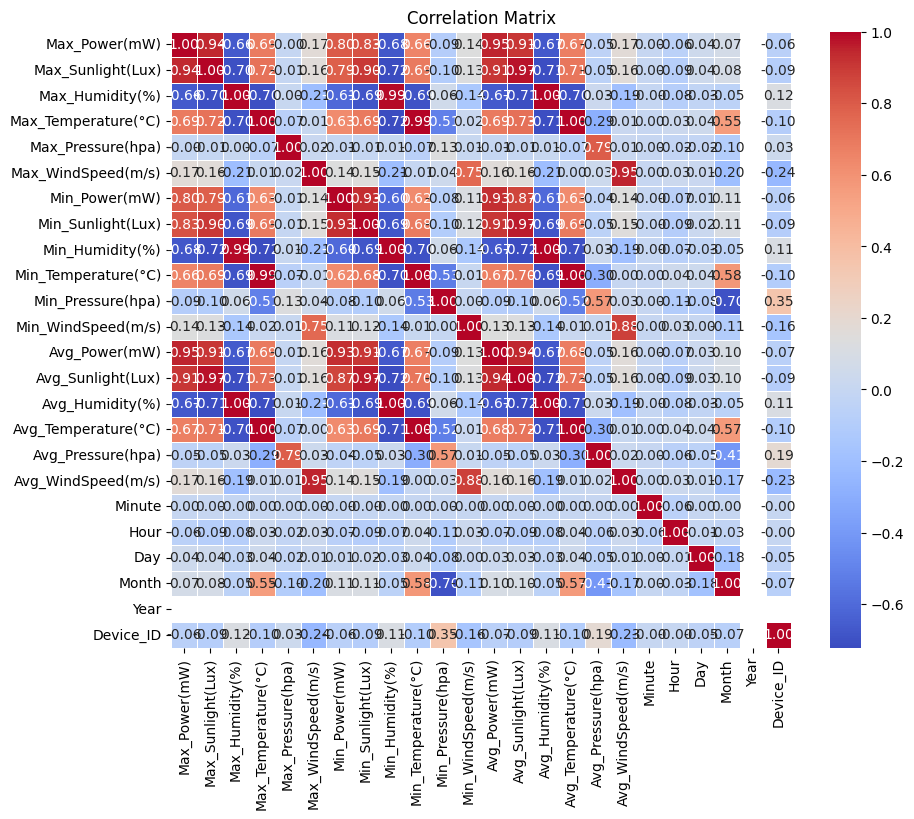

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

correlation_matrix = source_df.corr().iloc[::-1, ::-1]
print(correlation_matrix)

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

In [4]:
to_predict_features = 'Avg_Power(mW)'

correlation_df = pd.DataFrame(correlation_matrix)
filtered_df = correlation_df[correlation_df[to_predict_features].abs() >= 0.5]

print(filtered_df[to_predict_features].sort_values(ascending=False))

selected_features = filtered_df[to_predict_features].drop(to_predict_features).sort_values(ascending=False).index.to_list()
selected_features

Avg_Power(mW)          1.000000
Max_Power(mW)          0.946732
Avg_Sunlight(Lux)      0.942330
Min_Power(mW)          0.928239
Min_Sunlight(Lux)      0.910383
Max_Sunlight(Lux)      0.908408
Max_Temperature(°C)    0.690893
Avg_Temperature(°C)    0.683637
Min_Temperature(°C)    0.672835
Max_Humidity(%)       -0.666445
Avg_Humidity(%)       -0.670681
Min_Humidity(%)       -0.671765
Name: Avg_Power(mW), dtype: float64


['Max_Power(mW)',
 'Avg_Sunlight(Lux)',
 'Min_Power(mW)',
 'Min_Sunlight(Lux)',
 'Max_Sunlight(Lux)',
 'Max_Temperature(°C)',
 'Avg_Temperature(°C)',
 'Min_Temperature(°C)',
 'Max_Humidity(%)',
 'Avg_Humidity(%)',
 'Min_Humidity(%)']

In [5]:
# X_scaled_selected_features = StandardScaler().fit_transform(source_df[selected_features])
# X = pd.DataFrame(X_scaled_selected_features, columns=selected_features)
X = source_df[selected_features]
# X = pd.concat([source_df['Device_ID'], X], axis=1)
y = source_df[to_predict_features].to_frame()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=9500)

In [6]:
# model = make_pipeline(
#     PCA(),
#     PolynomialFeatures(),
#     LinearRegression(),
# )

# param_grid = {
#     'pca__n_components': [4, 5, 6, 7, 8, 9],
#     'polynomialfeatures__degree': [1, 2, 3, 4],
#     'linearregression__fit_intercept': [True, False]
# }
# grid_search = GridSearchCV(model, param_grid, cv=17, n_jobs=4)
# grid_search.fit(X_train, y_train)
# print(grid_search.best_params_)

In [7]:
model = make_pipeline(
    StandardScaler(),
    PCA(n_components=8),
    PolynomialFeatures(degree=4),
    LinearRegression(n_jobs=4),
)
model.fit(X_train,y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=8)),
                ('polynomialfeatures', PolynomialFeatures(degree=4)),
                ('linearregression', LinearRegression(n_jobs=4))])

In [8]:
y_pred = model.predict(X_test)

In [9]:
y_pred = np.clip(y_pred.round(2), 0, None)
y_pred_df = pd.DataFrame(y_pred,columns=y_test.columns)
y_test_df = pd.DataFrame(y_test,columns=y_test.columns).reset_index(drop=True)
print("Prediction\n",y_pred_df)
print("Ture\n",y_test_df)

Prediction
        Avg_Power(mW)
0               9.67
1              54.48
2              17.42
3             559.20
4               0.71
...              ...
32934          56.92
32935           6.27
32936         675.73
32937           3.25
32938          10.58

[32939 rows x 1 columns]
Ture
        Avg_Power(mW)
0              10.30
1              53.74
2              16.71
3             599.26
4               0.69
...              ...
32934          54.12
32935           5.96
32936         688.41
32937           3.10
32938          12.00

[32939 rows x 1 columns]


In [10]:
y_train.describe()

,Avg_Power(mW)
count,98816.000000
mean,244.903219
std,462.690669
min,0.000000
25%,1.810000
50%,16.770000
75%,187.142500
max,2272.620000


In [11]:
y_test_df.describe()

,Avg_Power(mW)
count,32939.000000
mean,246.708096
std,466.194943
min,0.000000
25%,1.810000
50%,17.110000
75%,185.515000
max,2201.340000


In [12]:
y_pred_df.describe()

,Avg_Power(mW)
count,32939.000000
mean,246.547800
std,465.592757
min,0.000000
25%,1.690000
50%,16.940000
75%,186.185000
max,2254.690000


In [13]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

error = abs(y_test_df[to_predict_features] - y_pred_df[to_predict_features])
mse = mean_squared_error(y_test_df, y_pred_df)
mae = mean_absolute_error(y_test_df, y_pred_df)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_df, y_pred_df)

print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'RMSE: {rmse}')
print(f'R2: {r2}')
print(f'Error Sum :{error.sum()}')


MSE: 492.45820054039285
MAE: 5.69513525000759
RMSE: 22.191399247014434
R2: 0.9977340650235534
Error Sum :187592.06000000003


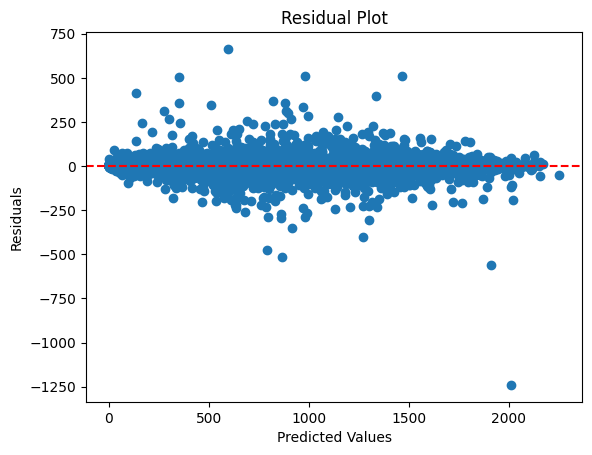

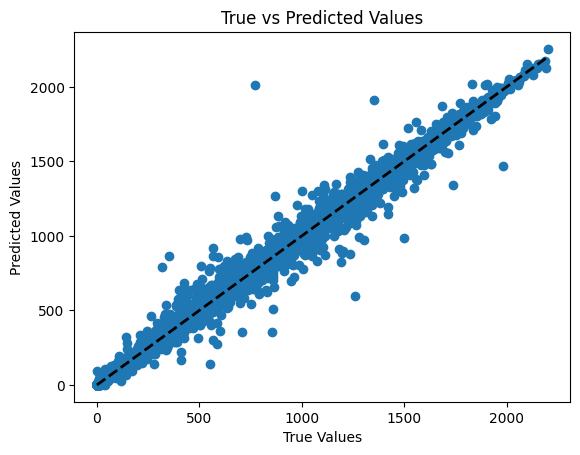

In [14]:
# 殘差圖（Residual Plot）
residuals = y_test_df - y_pred_df

plt.scatter(y_pred_df, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

# 畫出預測值和真實值的對比
plt.scatter(y_test_df, y_pred_df)
plt.plot([y_test_df.min(), y_test_df.max()], [y_test_df.min(), y_test_df.max()], 'k--', lw=2)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Values')
plt.show()

In [15]:
model.fit(X,y)
joblib.dump(model, '..//Model/pca8_poly4_linear.pkl')

['..//Model/pcv8_poly4_linear.pkl']

In [16]:
# Test Model
import os 

model = joblib.load("..//Model//pca8_poly4_linear.pkl")

files = os.listdir('..//Data//ProcessedData')
files.sort(key=lambda x: int(x[1:x.index('_')]))
import re

error = []
mse = []
mae = []
rmse = []
r2 = []

for file in files :
    data_df = pd.read_csv(f'..//Data//ProcessedData//{file}')
    X = data_df[selected_features]
    y = data_df[to_predict_features].to_frame()
    
    # X_scaled = StandardScaler().fit_transform(X)
    # X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

    y_pred = model.predict(X)
    y_pred = np.clip(y_pred.round(2), 0, None)
    y_pred_df = pd.DataFrame(y_pred, columns=y.columns)
    
    error.append(abs((y[to_predict_features] - y_pred_df[to_predict_features]).to_numpy()))
    
    
    mse_value = mean_squared_error(y, y_pred_df)
    mse.append(mse_value)
    
    mae_value = mean_absolute_error(y, y_pred_df)
    mae.append(mae_value)
    
    rmse_value = np.sqrt(mse_value)
    rmse.append(rmse_value)
    
    r2_value = r2_score(y, y_pred_df)
    r2.append(r2_value)

metrics_df = pd.DataFrame({
    'Device_ID': [int(re.search(r'\d+', filename).group()) for filename in files],
    'MAE': mae,
    'MSE': mse,
    'RMSE': rmse,
    'R2': r2
})

metrics_df

,Device_ID,MAE,MSE,RMSE,R2
0,1,4.566051,231.801915,15.225042,0.998927
1,2,4.826785,222.288634,14.909347,0.999174
2,3,6.566443,346.084849,18.603356,0.998649
3,4,8.504002,640.981091,25.317604,0.997397
4,5,7.286789,419.266902,20.476008,0.998411
5,6,7.038591,351.858393,18.757889,0.998916
6,7,6.986084,356.860899,18.890762,0.998953
7,8,3.861268,411.107383,20.275783,0.997009
8,9,4.334472,383.354470,19.579440,0.996474
9,10,5.640220,437.650995,20.920110,0.997022
